# Étude de l'erreur due à la diffusion et à la convection dans le cas du SWARM

In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
savefig = True
savefig_path = os.path.join(lib_path, "figures", "article_JCP_en/")

In [2]:
from src.main import *
from src.plot_fields import *

%matplotlib widget
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)
rc("font", size=18)
rc("legend", fontsize=16)
# %matplotlib inline
# rc('figure', figsize=(10,5))
# rc('figure', dpi=100)

## Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en WENO avec Euler explicite en temps.

In [3]:
Formulation = [Problem]
phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
phy_prop_ref = PhysicalProperties(
    Delta=0.02,
    v=0.0,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop = NumericalProperties(
    dx=3.9 * 10**-5,
    schema="quick",
    time_scheme="rk3",
    phy_prop=phy_prop,
    cfl=1.0,
    fo=1.0,
)
num_prop_ref = NumericalProperties(
    dx=3.9 * 10**-5,
    schema="weno",
    time_scheme="rk3",
    phy_prop=phy_prop,
    cfl=1.0,
    fo=1.0,
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=4)
# markers.shift(0.00001)

## Étude selon la formulation de l'équation

En fait s'il n'y a pas de convection il n'y a pas de différence entre les différentes formes, à l'exception de la moyenne utilisée pour $\frac{1}{\rho C_p}$

### RK4


Ref
===
dt fourier
6.918433404737903e-06
Db / dx = 07

TOF
===
dt fourier
6.918433404737903e-06
Db / dx = 07
TOF dE*/dt* = -0.000003


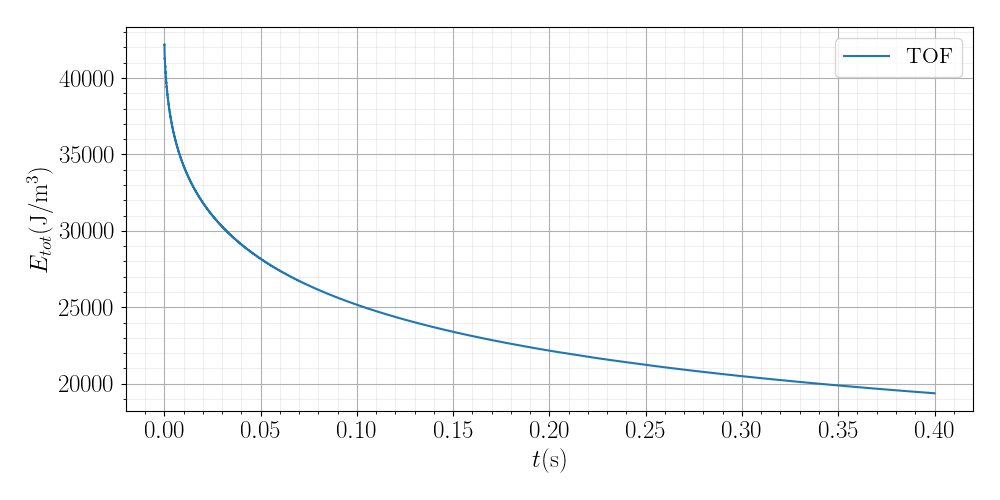

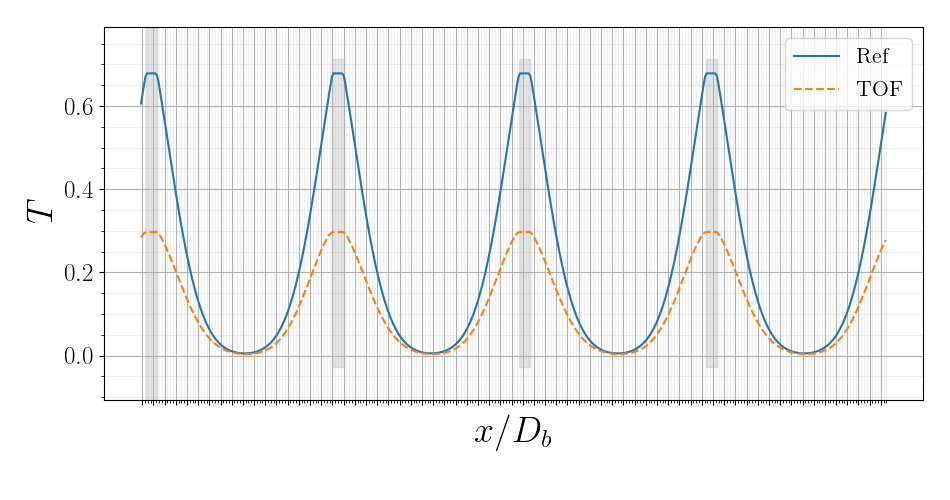

In [4]:
fig1, ax1 = plt.subplots(1)
plot = Plotter("decale", markers=False, time=False, ispretty=True)
t_fin = 0.4
# ax1.set_title('Énergie en fonction du temps')
# fig2, ax2 = plt.subplots(1)
# ax2.set_title('Énergie adimensionnée en fonction du temps adim')
prob_ref = Problem(
    get_T_creneau,
    phy_prop=phy_prop_ref,
    num_prop=num_prop_ref,
    markers=markers,
    name="Ref",
)
t, e = prob_ref.timestep(t_fin=t_fin, number_of_plots=1, debug=None, plotter=plot)
prob = Problem(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
E0 = prob.energy
t, e = prob.timestep(t_fin=t_fin, number_of_plots=1, debug=None, plotter=plot, ls="--")
l = ax1.plot(t, e / (0.02 * 0.005**2), label="TOF")
ax1.legend()
ax1.set_ylabel(r"$E_{tot}$(J/m$^3$)")
ax1.set_xlabel(r"$t \textrm{(s)}$")
n = len(e)
i0 = int(n / 5)
# ax2.plot(t/prob.dt, e / E0, label=prob.name)
dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
# par Dt / rho_cp_l T_l V
print(prob.name, "dE*/dt* = %f" % dedt_adim)
# le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which="major")
ax1.grid(b=True, which="minor", alpha=0.2)
plot.ax.set_xticklabels([])
fig1.tight_layout()
if savefig:
    fig1.savefig(savefig_path + "energy_loss_1D.pdf")
    plot.fig.savefig(savefig_path + "temperature_energy_loss_1D.pdf")

### Euler

In [5]:
Formulation = [Problem, ProblemConserv2]
phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop = NumericalProperties(
    dx=3.9 * 10**-5,
    schema="weno",
    time_scheme="euler",
    phy_prop=phy_prop,
    cfl=0.5,
    fo=1.0,
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
# markers.shift(0.00001)


TOF
===
dt fourier
6.918433404737903e-06
Db / dx = 30
TOF dE*/dt* = -0.000001

EOFm
====
dt fourier
6.918433404737903e-06
Db / dx = 30
EOFm dE*/dt* = 0.000002


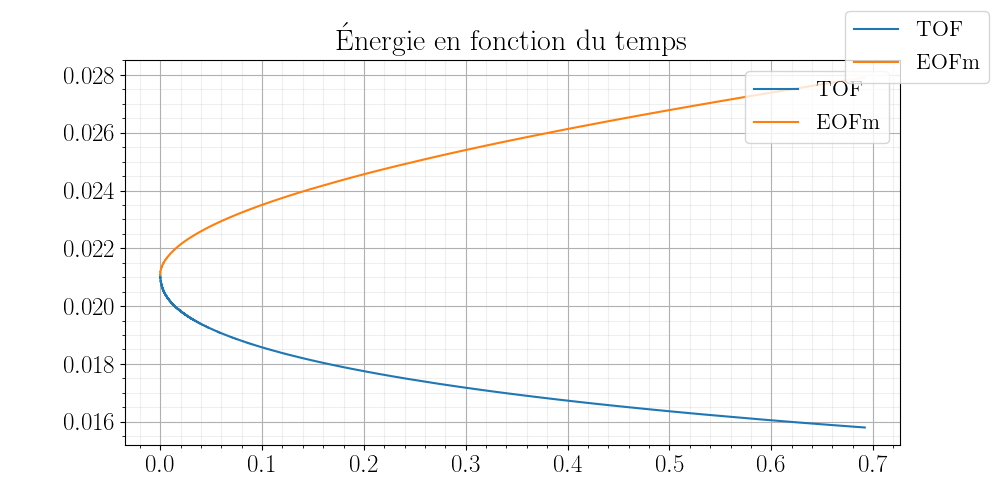

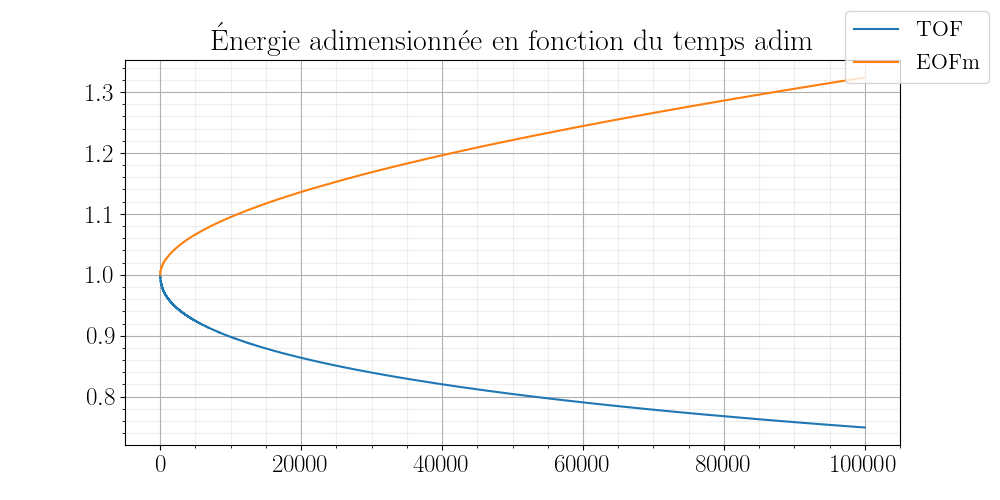

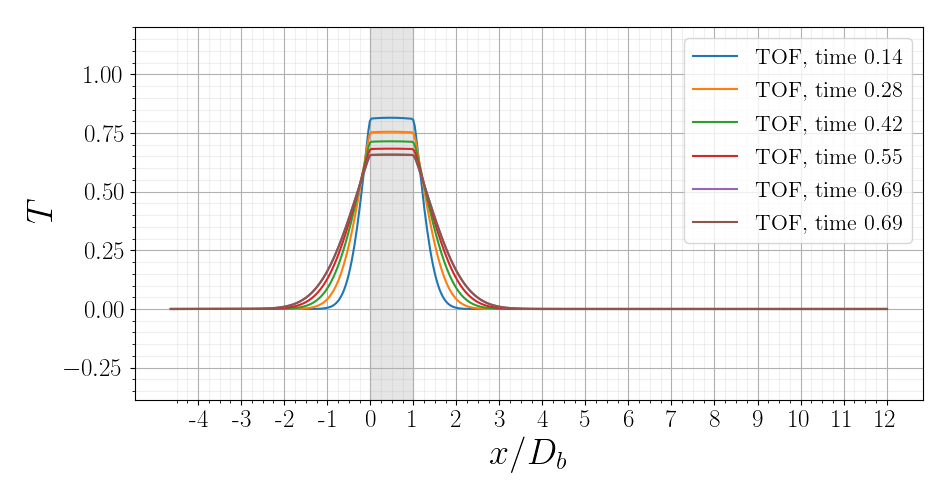

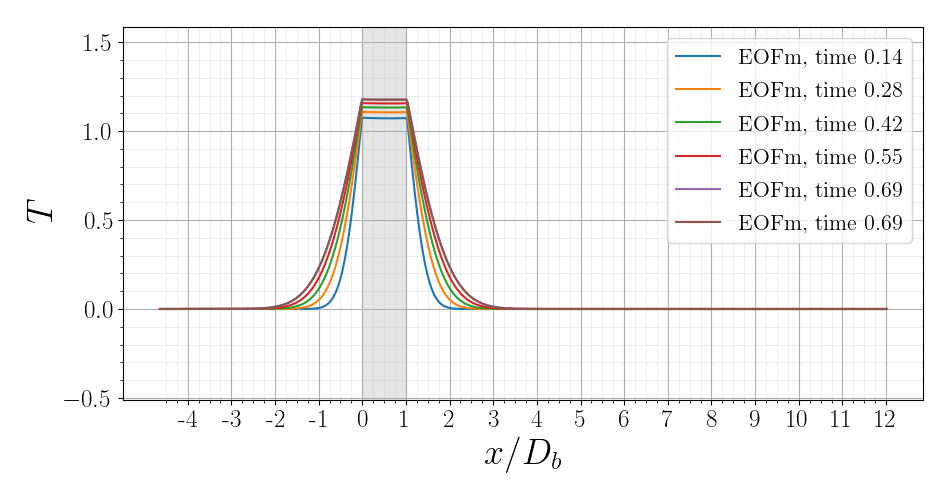

In [6]:
fig1, ax1 = plt.subplots(1)
ax1.set_title("Énergie en fonction du temps")
fig2, ax2 = plt.subplots(1)
ax2.set_title("Énergie adimensionnée en fonction du temps adim")
for form in Formulation:
    prob = form(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
    E0 = prob.energy
    t, e = prob.timestep(
        n=100000, number_of_plots=5, debug=None, plotter=Plotter("decale")
    )
    l = ax1.plot(t, e, label=prob.name)
    ax1.legend()
    n = len(e)
    i0 = int(n / 5)
    ax2.plot(t / prob.dt, e / E0, label=prob.name)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print(prob.name, "dE*/dt* = %f" % dedt_adim)
le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which="major")
ax1.grid(b=True, which="minor", alpha=0.2)
le = fig2.legend()
ax2.minorticks_on()
ax2.grid(b=True, which="major")
ax2.grid(b=True, which="minor", alpha=0.2)

## Cas boniou, euler avec weno et upwind quand le stencil traverse l'interface

In [7]:
Formulation = [Problem, ProblemConserv2]
phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop = NumericalProperties(
    dx=3.9 * 10**-5,
    schema="weno upwind",
    time_scheme="euler",
    phy_prop=phy_prop,
    cfl=0.5,
    fo=1.0,
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
# markers.shift(0.00001)


TOF
===
dt fourier
6.918433404737903e-06
Db / dx = 30
TOF dE*/dt* = -0.000002

EOFm
====
dt fourier
6.918433404737903e-06
Db / dx = 30
EOFm dE*/dt* = 0.000001


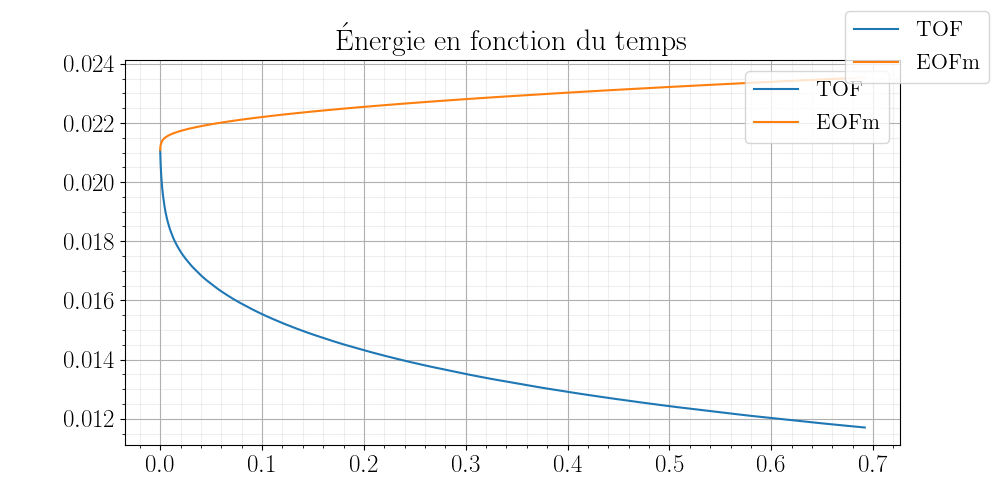

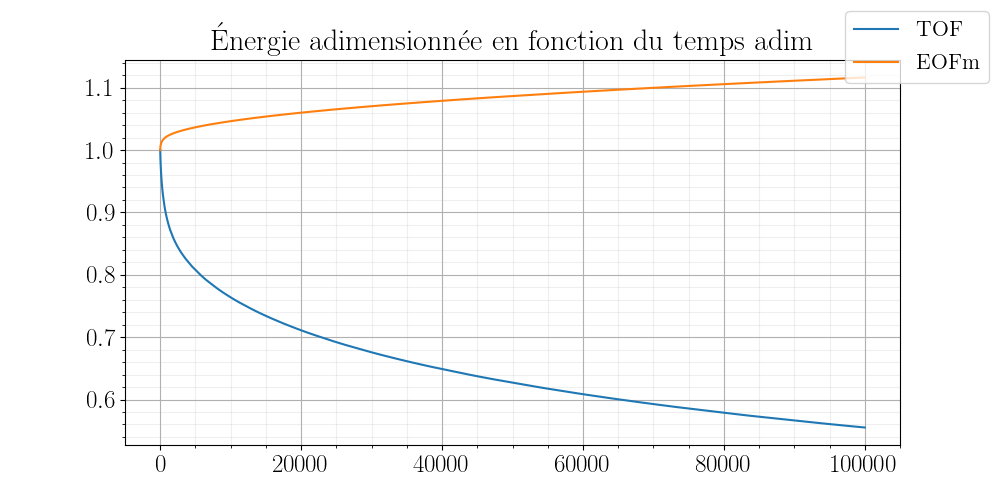

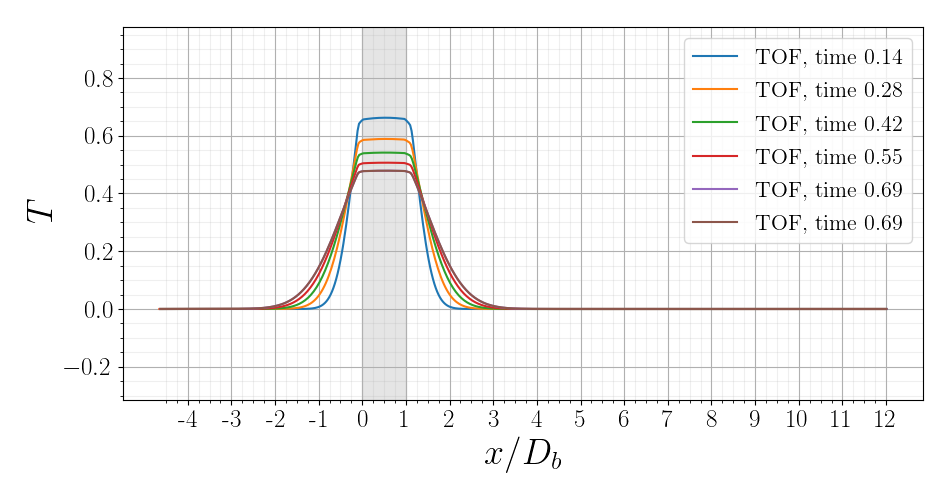

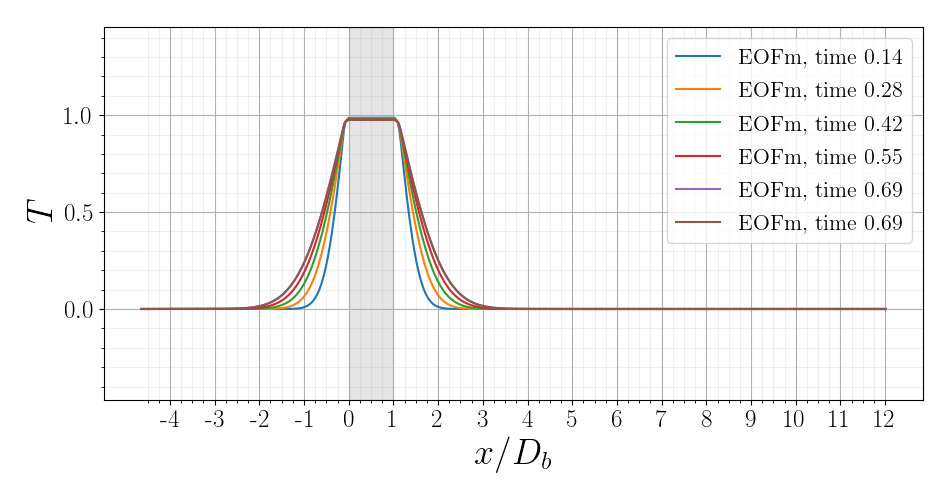

In [8]:
fig1, ax1 = plt.subplots(1)
ax1.set_title("Énergie en fonction du temps")
fig2, ax2 = plt.subplots(1)
ax2.set_title("Énergie adimensionnée en fonction du temps adim")
for form in Formulation:
    prob = form(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
    E0 = prob.energy
    t, e = prob.timestep(
        n=100000, number_of_plots=5, debug=None, plotter=Plotter("decale")
    )
    l = ax1.plot(t, e, label=prob.name)
    ax1.legend()
    n = len(e)
    i0 = int(n / 5)
    ax2.plot(t / prob.dt, e / E0, label=prob.name)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print(prob.name, "dE*/dt* = %f" % dedt_adim)
le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which="major")
ax1.grid(b=True, which="minor", alpha=0.2)
le = fig2.legend()
ax2.minorticks_on()
ax2.grid(b=True, which="major")
ax2.grid(b=True, which="minor", alpha=0.2)